In [1]:
import sys
sys.path.append('../')

from Modules.Utils.Imports import *
from Modules.Utils.ModelWrapper import ModelWrapper
from Modules.Models.BuildBINNs import BINN

import Modules.Loaders.DataFormatter as DF

In [2]:
device = torch.device(GetLowestGPU(pick_from=[0,1,2,3]))

Device set to cpu


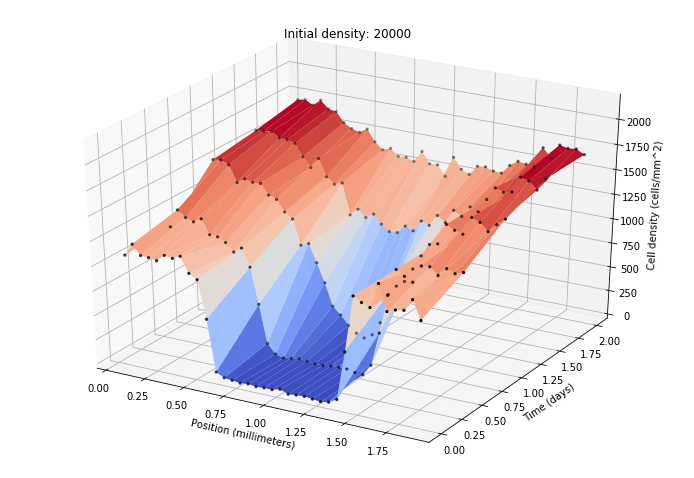

In [3]:
path = '../Data/'
file_name = 'cell_density_profiles.npy'
densities = ['dens_10000', 'dens_12000', 'dens_14000', 
             'dens_16000', 'dens_18000', 'dens_20000']
density_idx = 5 # 0, ..., 5
density = densities[density_idx]
gamma = 0.2

inputs, outputs, shape = DF.load_cell_migration_data(path+file_name, density_idx, plot=True)

In [4]:
def to_torch(ndarray):
    arr = torch.tensor(ndarray, dtype=torch.float)
    arr.requires_grad_(True)
    arr = arr.to(device)
    return arr

# split into train/val and convert to torch
N = len(inputs)
split = int(0.8*N)
p = np.random.permutation(N)
x_train = to_torch(inputs[p[:split]])
y_train = to_torch(outputs[p[:split]])
x_val = to_torch(inputs[p[split:]])
y_val = to_torch(outputs[p[split:]])
inputs = to_torch(inputs)
outputs = to_torch(outputs)

In [5]:
# initialize model
binn = BINN(delay=True)
binn.to(device)

# compile 
parameters = binn.parameters()
opt = torch.optim.Adam(parameters, lr=1e-3)
model = ModelWrapper(
    model=binn,
    optimizer=opt,
    loss=binn.loss,
    augmentation=None,
    save_name='../Weights/test')

In [ ]:
epochs = int(1e6)
batch_size = 37
rel_save_thresh = 0.05

# train jointly
model.fit(
    x=x_train,
    y=y_train,
    batch_size=batch_size,
    epochs=epochs,
    callbacks=None,
    verbose=1,
    validation_data=[x_val, y_val],
    early_stopping=5000,
    rel_save_thresh=rel_save_thresh)

In [ ]:
# load training errors
total_train_losses = model.train_loss_list
total_val_losses = model.val_loss_list

# find where errors decreased
train_idx, train_loss, val_idx, val_loss = [], [], [], []
best_train, best_val = 1e12, 1e12
for i in range(len(total_train_losses)-1):
    rel_diff = (best_train - total_train_losses[i])
    rel_diff /= best_train
    if rel_diff > rel_save_thresh:
        best_train = total_train_losses[i]
        train_idx.append(i)
        train_loss.append(best_train)
    rel_diff = (best_val - total_val_losses[i])
    rel_diff /= best_val
    if rel_diff > rel_save_thresh:
        best_val = total_val_losses[i]
        val_idx.append(i)
        val_loss.append(best_val)
idx = np.argmin(val_loss)

# plot
fig = plt.figure(figsize=(15,5))
ax = fig.add_subplot(1, 2, 1)
plt.semilogy(total_train_losses, 'b')
plt.semilogy(total_val_losses, 'r')
plt.semilogy(val_idx[idx], val_loss[idx], 'ko')
plt.legend(['train mse', 'val mse', 'best val'])
plt.xlabel('epochs')
plt.ylabel('MSE')
plt.title('Train/Val errors')
plt.grid()
ax = fig.add_subplot(1, 2, 2)
plt.semilogy(train_idx, train_loss, 'b.-')
plt.semilogy(val_idx, val_loss, 'r.-')
plt.legend(['train mse', 'val mse'])
plt.xlabel('epochs')
plt.ylabel('MSE')
plt.title('Train/Val improvements')
plt.grid()
plt.show()